
# **Assignment 2: Regularization, Auto-encoders and XAI - November 2024**



> - **Author:** Elio Gargiulo
- **ID:** 869184
- **Course:** Advanced Machine Learning
- **A.Y:** 2024/25
- **University:** Milano Bicocca - Master Degree in Computer Science


# **Predicting Multi-MNIST digits**.

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

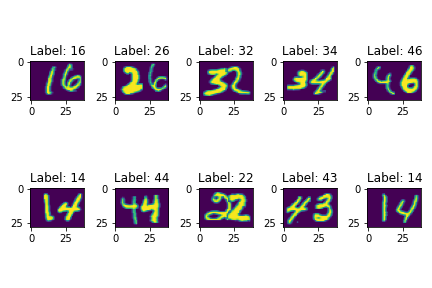

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

## **Initialization**

> Before starting with the project itself, let's import the libraries and the data that will be used to achive our goals

### **Initialization: Libraries**

> Importing the necessary libraries.

In [ ]:
from keras.models import Sequential, Model                           # For NNs
from keras.layers import Dense, Activation, Input, Dropout           # For NNs
from keras.optimizers import Adam                                    # For NNs
import numpy as np                                                   # For Numerical Computing
import pandas as pd                                                  # For Dataset Analysis
import matplotlib.pyplot as plt                                      # For Plots
import seaborn as sns                                                # For Plots
from sklearn.preprocessing import StandardScaler                     # For Standard Scaling
from sklearn.metrics import classification_report                    # For Metrics
from google.colab import drive                                       # For Dataset Importing
from google.colab import files                                       # For Predictions
from keras.utils import to_categorical                               # For Casting
from sklearn.model_selection import train_test_split                 # For Splitting
from tensorflow.keras import regularizers                            # For Regularization
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For Autoencoder
from keras.callbacks import EarlyStopping                            # For Regularization
from sklearn.metrics import confusion_matrix                         # For Metrics
from xgboost import XGBClassifier                                    # For XGBoost
from sklearn.decomposition import PCA                                # For PCA
from sklearn.metrics import log_loss                                 # For Evaluation
from sklearn.metrics import accuracy_score                           # For Evaluation

### **Initialization: Importing the Data**

> In this case the dataset is uploaded on Google Drive, so we need to import it using Google Colab.

In [ ]:
# Mouting the drive
drive.mount('/content/drive')

# Saving the main path to the data
main_path = '/content/drive/MyDrive/Colab Notebooks/Assignment 2/dataset/'

# Building the correct path for each file
X_train_path = main_path + 'x_train.npy'
X_test_path = main_path + 'x_test.npy'
y_train_path = main_path + 'y_train.npy'
y_test_path = main_path + 'y_test.npy'

# Loading the already split train data into the project
X_train = np.load(X_train_path)
y_train = np.load(y_train_path)

# Loading the already split test data into the project
X_test = np.load(X_test_path)
y_test = np.load(y_test_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Inspecting the Data**

> In this section there will be a simple analysis of the data given. This will help understand how the data is distributed and which labels need to be classified.

In [ ]:
# Function for showing the images
def show_head(data, num_images=5):
  # Setting up the size
  plt.figure(figsize=(5, num_images))
  # Plotting
  for i in range(num_images):
      plt.subplot(1, num_images, i + 1)
      plt.imshow(data[i])
      plt.axis('off')
  plt.show()

> This function will help display the first images of our data, since we are not using pandas functions.

### **Inspecting the Data: Number of Images and Features**

> *shape* returns a tuple which contains, in this case since we have grayscale images, in order:
  - Number of the images in the set.
  - The height of the image (pixels).
  - The width of the image (pixels).

> Let's analyse the data using the *shape* method and the function that has been implemented above. We can see that the images load correctly and that we have for training:
  - 72247: total number of images.
  - 28: height of each image.
  - 39: width of each image.



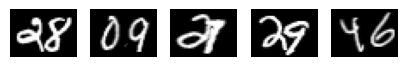

(72247, 28, 39)


In [ ]:
# Show the first 5 train images
show_head(X_train)
# Shape
print(X_train.shape)

> We can see that the images load correctly and that we have for test:
  - 24083: total number of images.
  - 28: height of each image.
  - 39: width of each image.

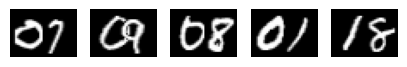

(24083, 28, 39)


In [ ]:
# Show the first 5 test images
show_head(X_test)
# Shape
print(X_test.shape)

> Focusing on the label we can see that there are 50 different categories, corresponding to each number. Later there will be an analysis regarding the actual range of the numbers (0 to 49 or 1 to 50).

In [ ]:
print('Number of categories (train):',len(set(y_train)))

Number of categories (train): 50


> We have exactly the same amount corresponding to the train data.

In [ ]:
y_train.shape

(72247,)

> The same can be said for the test data.

In [ ]:
print('Number of categories (test):',len(set(y_test)))

Number of categories (test): 50


In [ ]:
y_test.shape

(24083,)

### **Inspecting the Data: Plots**

> Focusing on the labels (target), the following plots will analyze the distribution of each label.

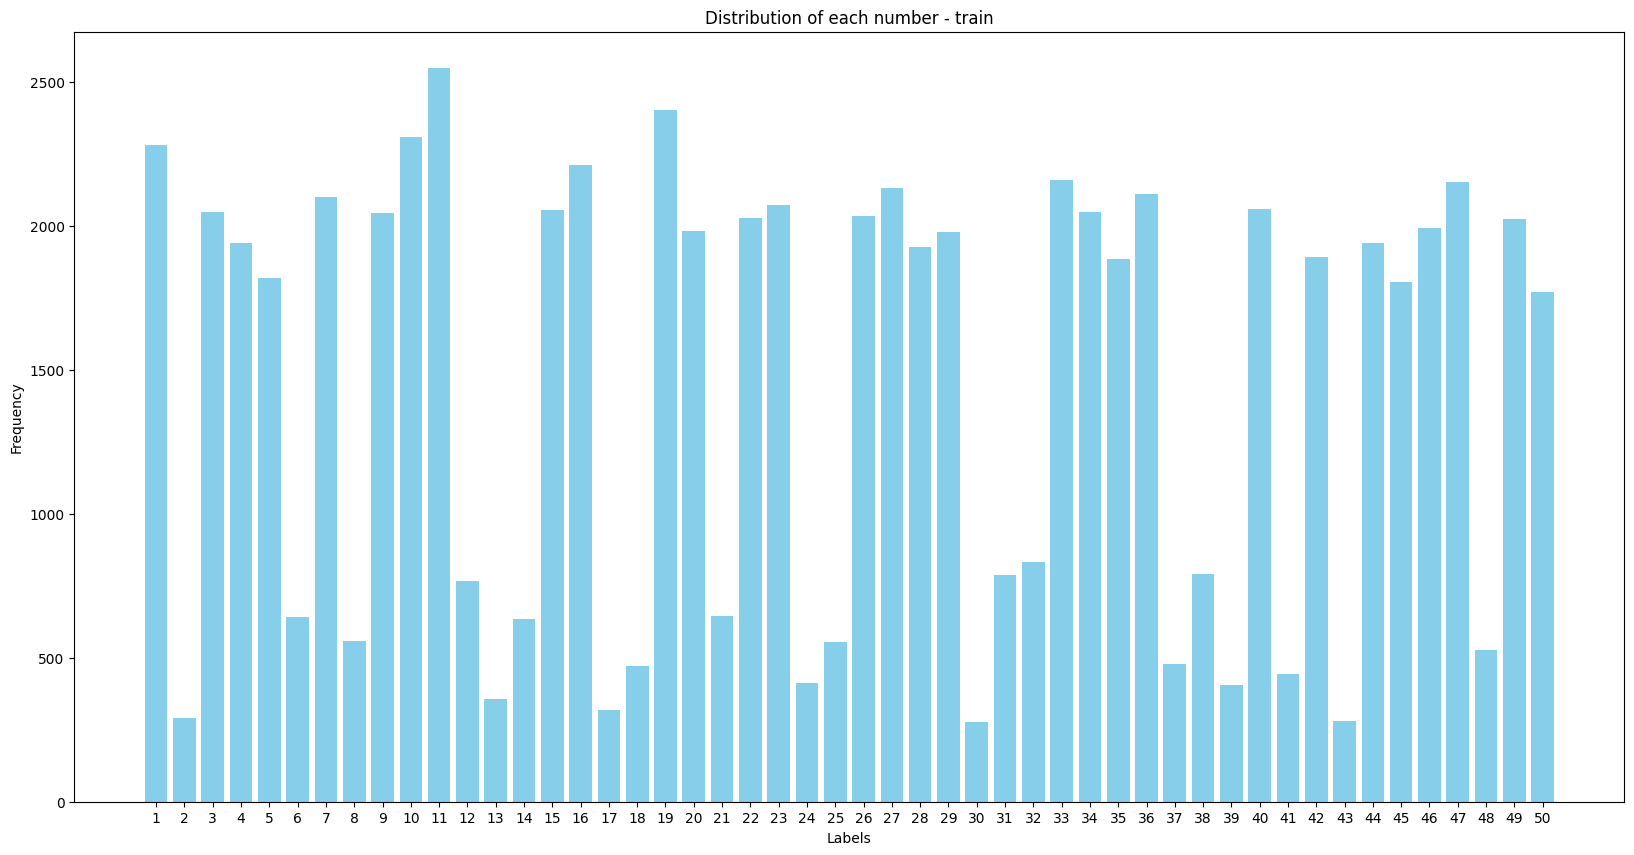

In [ ]:
# Counting for each unique feature its frequency
unique, counts = np.unique(y_train, return_counts=True)

# Plot the results in a barplot
plt.figure(figsize=(20, 10))
plt.bar(unique, counts, color='skyblue')
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of each number - train")
plt.xticks(unique)
plt.show()

> The bar plot shows that we have 50 numbers to classify, which are indeed our labels. Their distribuition is not very uniform, so numbers like 2 or 30 will be harder to classify correctly.

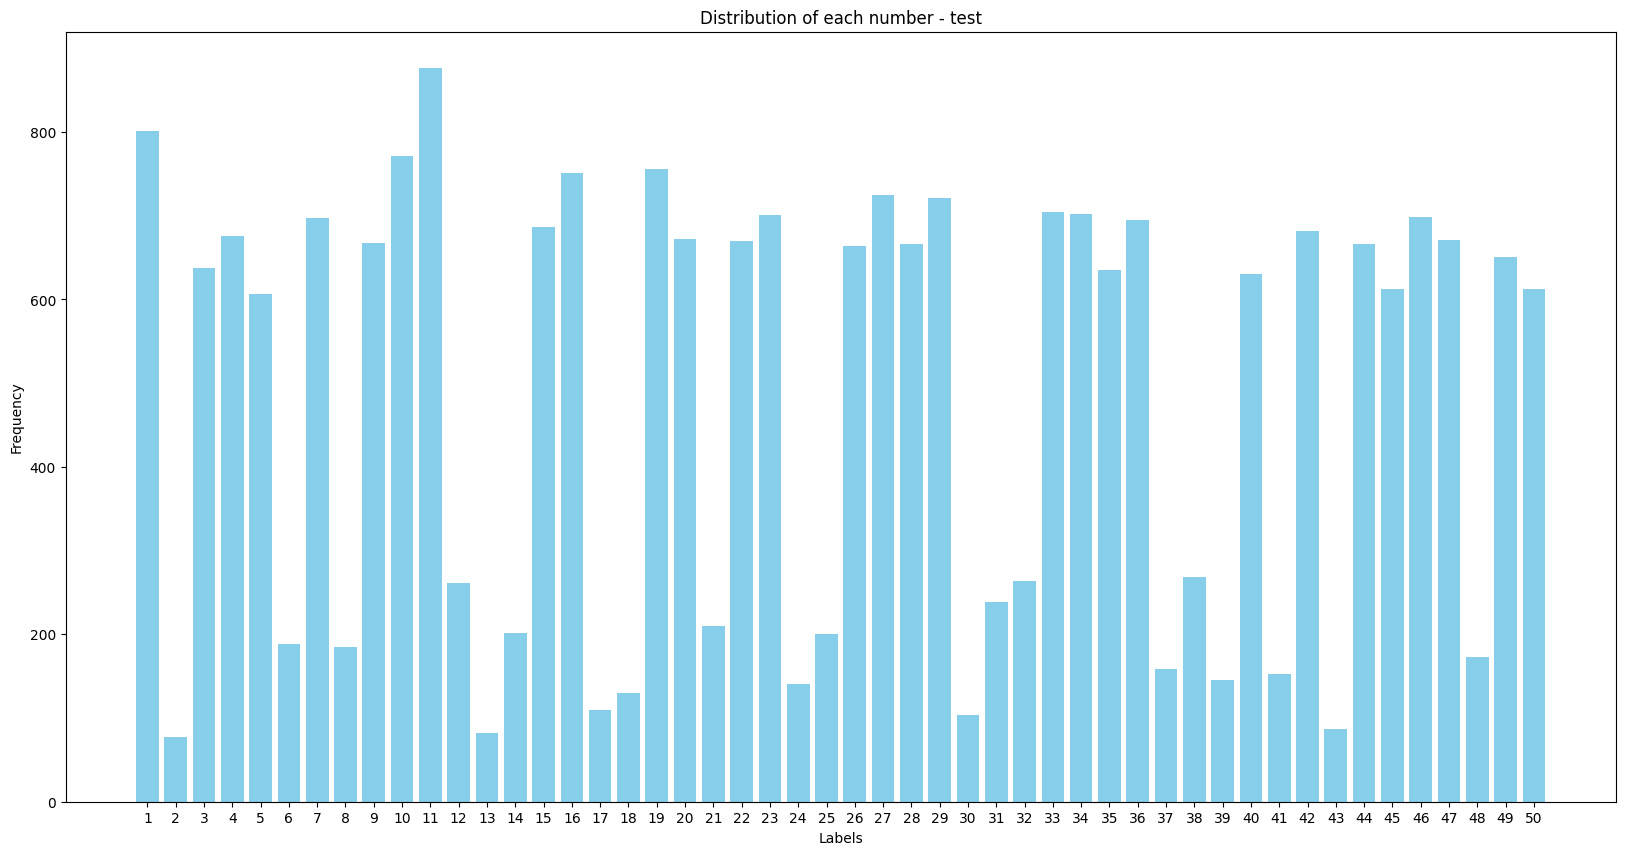

In [ ]:
# Counting for each unique feature its frequency
unique, counts = np.unique(y_test, return_counts=True)

# Plot the results in a barplot
plt.figure(figsize=(20, 10))
plt.bar(unique, counts, color='skyblue')
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of each number - test")
plt.xticks(unique)
plt.show()

> On the test set we can see exactly what we have seen before.

## **Preparing the data**

> In this section the data will be prepared to be ready for the next steps with the models. First there will be a confirmation about the real range of our labels and then the actual preparation with reshaping and normalization.


### **Preparing the data: Preliminaries**

> The following function will return the index of the list of y_train where the label given as argument is present.

In [ ]:
def find_label(label):
  indices = np.where(y_train == label)[0]
  # Show the first index where the label is {label}
  first_index = indices[0] if len(indices) > 0 else None
  print("First index where the label " + str(label) + " is:", first_index)

In [ ]:
find_label(0)

First index where the label 0 is: None


> This confirms that our labels are indeed from 1 to 50.

In [ ]:
find_label(50)

First index where the label 50 is: 60


> We have confirmed that there is an image with 50, so we need to keep it in mind while doing *to_categorical*.

In [ ]:
find_label(1)

First index where the label 1 is: 5


### **Preparing the data: Reshape and Normalization**

> The actual data preparation consists in the following steps:

 > - Data Reshaping: Each sample in the dataset is reshaped to have a single dimension of 1092 features (28 * 39), which will be used as input size for the NN.

  >- Casting: The data type of the training and testing sets is converted to float32.

  >- Normalization: Pixel values are normalized by dividing by 255, scaling them to the range [0, 1]. This helps in stabilizing and speeding up training by keeping input values in a similar range.

  >- One-Hot Encoding: Since we have 50 different labels (categories), the idea is to use in the creation of the models the loss function categorical_crossentropy. Labels need to be one-hot encoded into vectors of 50 classes (for labels 0 to 49).

In [ ]:
# Reshaping the data to have 28 * 39 features per sample
X_train = X_train.reshape(72247, 1092)  # 28 * 39 = 1092
X_test = X_test.reshape(24083, 1092)

# Converting data type to float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalizing pixel values to the range [0, 1]
X_train /= 255
X_test /= 255

# Adjusting labels to start from 0 instead of 1 (needed for to_categorical)
y_train = y_train - 1
y_test = y_test - 1

# Converting labels to one-hot encoding with 50 classes (labels 0 to 49)
y_train = to_categorical(y_train, 50)
y_test = to_categorical(y_test, 50)


> Confirming now that some images and labels are corresponding correctly.

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

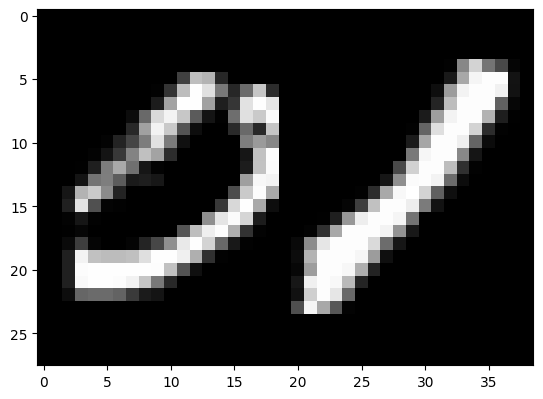

In [ ]:
# Confirm that the labels correspond to the image
plt.imshow(X_train[5].reshape(28, 39))
y_train[5]

> The number 1 is indeed in first position of the array.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

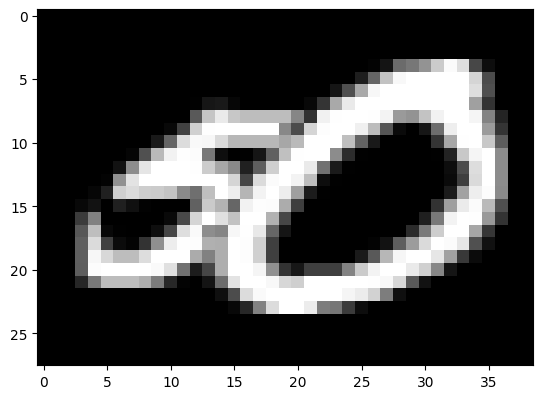

In [ ]:
# Confirm that the labels correspond to the image
plt.imshow(X_train[60].reshape(28, 39))
y_train[60]

> The number 1 is indeed in last position of the array, corrisponding to 50.

### **Preparing the data: Split Training and Validation Data**

> Finally, before implementing the NNs we can split the data to get the validation set to be used for validation our NN.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

> Let's check the new sizes of the train and validation sets.

In [ ]:
print('Size of the train set:', X_train.shape)

Size of the train set: (54185, 1092)


In [ ]:
print('Size of the val set:', X_val.shape)

Size of the val set: (18062, 1092)


# **1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]**





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

## **1.1 Non-regularized Model**


### **1.1.1 Building the network**

> The non-regularized model has been built following this reasoning:
- **4 hidden layers**: we start from an input siuze of 1092, so the idea is to slowly decrease the amount of neurons to 50, therefore we have 512, 256, 128 and finally 64. The activation function is *ReLU* (*tanh* could be used too). Adding more hidden layers and increasing the complexity of the NN can increase the risk of overfitting, as the model may start to memorize more intricate patterns in the data. However, in this case, this added complexity is not a problem, as it makes the comparison and the effects of regularization more visible.
- **Softmax**: it returns values between 0 and 1, which is consistent also with the normalization done before to the pixels. Also it's a good choice when the target is multiclass.
- **categorical_crossentropy**: as mentioned in the section of *Preparing the data*, this loss function works well with categories.
- **Adam**: usually the best optimizer, especially because it converges faster. The learning rate has been kept as the default value.

In [ ]:
# Setting up the input shape
dims = X_train.shape[1]

# Amount of categories
nb_classes = 50

# The model without regularization: four hidden layers
model_noreg = Sequential()
model_noreg.add(Input((dims,)))
model_noreg.add(Dense(512, activation = "relu"))
model_noreg.add(Dense(256, activation = "relu"))
model_noreg.add(Dense(128, activation = "relu"))
model_noreg.add(Dense(64, activation = "relu"))
# Softmax for multiclass classification. We have 50 output neurons
model_noreg.add(Dense(nb_classes, activation = "softmax"))

# Compiling using Adam and categorical_crossentropy
model_noreg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_noreg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

### **1.1.2 Analyze and comment on the training results**

> As stating point we will use 20 epochs and 128 batch_size to get a quick training.

In [ ]:
history_noreg = model_noreg.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5748 - loss: 1.6473 - val_accuracy: 0.8533 - val_loss: 0.4972
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8876 - loss: 0.3795 - val_accuracy: 0.9054 - val_loss: 0.3156
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9283 - loss: 0.2317 - val_accuracy: 0.9074 - val_loss: 0.3046
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9478 - loss: 0.1644 - val_accuracy: 0.9153 - val_loss: 0.2716
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9610 - loss: 0.1195 - val_accuracy: 0.9264 - val_loss: 0.2579
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9680 - loss: 0.0944 - val_accuracy: 0.9249 - val_loss: 0.2709
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9746 - loss: 0.0748 - val_accuracy: 0.9329 - val_loss: 0.2506
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0611 - val_accuracy:

> We can see that already with 20 epochs the model converges quickly. Even ignoring the validation, the training accuracy is very very high (same for the loss, very low), reaching 99%. This is very suspect and looking at the graphs in the next section will confirm indeed that there is some overfitting.

### **1.1.3 Validate the model and comment on the results**

In [ ]:
# Functions to plot loss and accuracy
def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

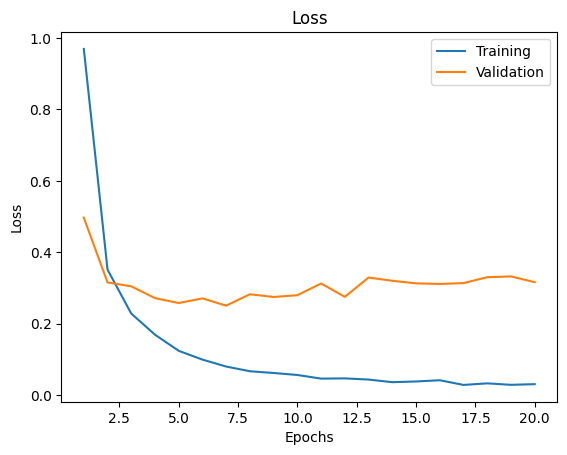

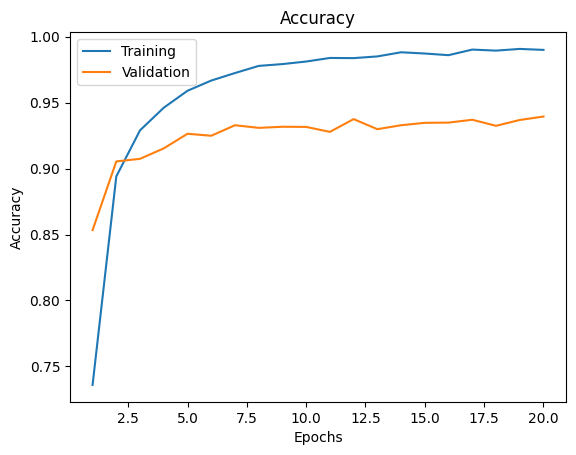

In [ ]:
# Plotting the data
plot_loss(history_noreg)
plot_accuracy(history_noreg)

> Looking at the above plots there is the confirmation that there is some actual overfitting. The train curve (blue one) reaches around 99% in accuracy and close to 0 in loss, while the validation curve is much lower in accuracy, around 94% and a loss around 0.32. This means that the model is not really generalizing and will definitely perform worse on new data but the performance is not bad.

## **1.2 Regularized Model**


### **1.2.0 Regularized Model - Preliminaries**

> Before implementing the definitive regularized model let's see how the techniques shown in class alter the non-regularized model. This will help chosing the best technique.

> The analysis will be on:
  - **L1 Regularization**: it's expected to perform worse since it nullifies the weights to 0 (feature selection). Since we have images, each pixel contains valuable data, therefore it's not a good approach.
  - **L2 Regularization**: it's expected to perform better than L1, since this time the weight will be lowered, but not reaching 0, preserving the pixel information.
  - **Dropout**: Adding some dropout layers to penalize the network should help the generalization.

> Finally, for the final regularized model, early stopping will be used too, this way the selection of the amount epochs will not impact much the model.

#### **L1 Regularization**

In [ ]:
# The model is built following the non-regularized one.
# λ is unspecified, as it uses the default value of 0.01
model_regl1 = Sequential()
model_regl1.add(Input((dims,)))
model_regl1.add(Dense(512, activation = "relu", kernel_regularizer=regularizers.l1, bias_regularizer=regularizers.l1))
model_regl1.add(Dense(256, activation = "relu", kernel_regularizer=regularizers.l1, bias_regularizer=regularizers.l1))
model_regl1.add(Dense(128, activation = "relu", kernel_regularizer=regularizers.l1, bias_regularizer=regularizers.l1))
model_regl1.add(Dense(64, activation = "relu", kernel_regularizer=regularizers.l1, bias_regularizer=regularizers.l1))
model_regl1.add(Dense(nb_classes, activation = "softmax"))
# Compiling the model
model_regl1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_regl1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model using the same parameters
history_regl1 = model_regl1.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.0354 - loss: 60.1013 - val_accuracy: 0.0348 - val_loss: 4.6789
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0347 - loss: 4.6792 - val_accuracy: 0.0348 - val_loss: 4.6768
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0359 - loss: 4.6701 - val_accuracy: 0.0348 - val_loss: 4.6745
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0372 - loss: 4.6685 - val_accuracy: 0.0348 - val_loss: 4.6662
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0350 - loss: 4.6664 - val_accuracy: 0.0348 - val_loss: 4.6605
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0357 - loss: 4.6629 - val_accuracy: 0.0348 - val_loss: 4.6613
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0359 - loss: 4.6617 - val_accuracy: 0.0348 - val_loss: 4.6567
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0350 - loss: 4.6640 - val_accuracy:

> It's already visible how poor are the performance, confirming that l1 might not be the correct approach.

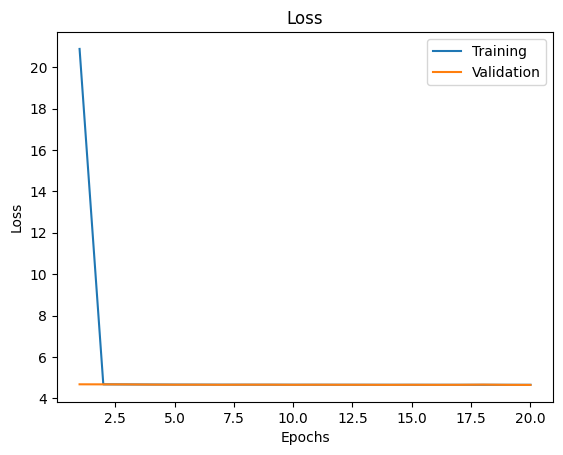

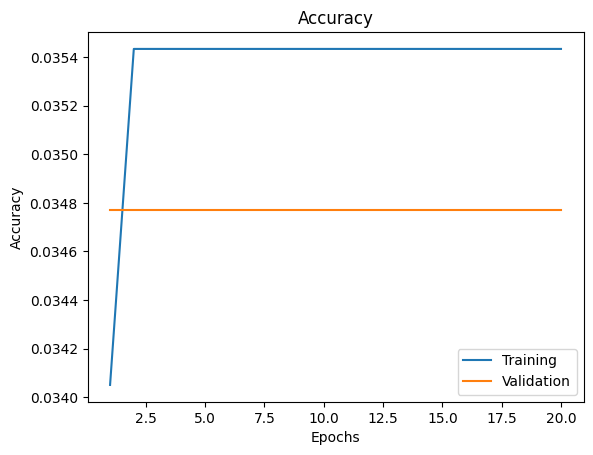

In [ ]:
# Plotting the history
plot_loss(history_regl1)
plot_accuracy(history_regl1)

> The plots are basically constants.

#### **L2 Regularization**

In [ ]:
# The model is built following the non-regularized one.
# λ is unspecified, as it uses the default value of 0.01
model_regl2 = Sequential()
model_regl2.add(Input((dims,)))
model_regl2.add(Dense(512, activation = "relu", kernel_regularizer=regularizers.l2, bias_regularizer=regularizers.l2))
model_regl2.add(Dense(256, activation = "relu", kernel_regularizer=regularizers.l2, bias_regularizer=regularizers.l2))
model_regl2.add(Dense(128, activation = "relu", kernel_regularizer=regularizers.l2, bias_regularizer=regularizers.l2))
model_regl2.add(Dense(64, activation = "relu", kernel_regularizer=regularizers.l2, bias_regularizer=regularizers.l2))
model_regl2.add(Dense(nb_classes, activation = "softmax"))
# Compiling the model
model_regl2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_regl2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model using the same parameters
history_regl2 = model_regl2.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4362 - loss: 5.8260 - val_accuracy: 0.6793 - val_loss: 2.0315
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7362 - loss: 1.8486 - val_accuracy: 0.7536 - val_loss: 1.6684
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7815 - loss: 1.5923 - val_accuracy: 0.8145 - val_loss: 1.4844
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8131 - loss: 1.4607 - val_accuracy: 0.8293 - val_loss: 1.3808
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8282 - loss: 1.3723 - val_accuracy: 0.8114 - val_loss: 1.3934
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8387 - loss: 1.3063 - val_accuracy: 0.8383 - val_loss: 1.2962
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8470 - loss: 1.2692 - val_accuracy: 0.8460 - val_loss: 1.2510
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8538 - loss: 1.2261 - val_accuracy: 0

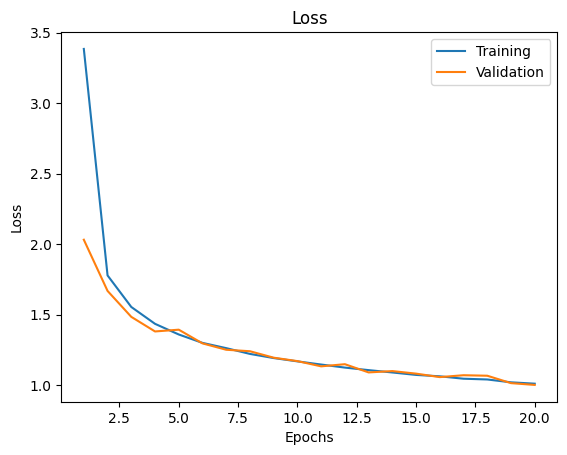

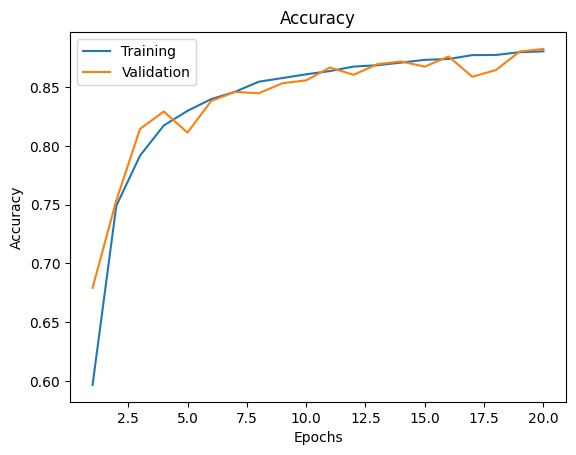

In [ ]:
# Plotting the history
plot_loss(history_regl2)
plot_accuracy(history_regl2)

> L2 shows a really good improvement in the generalization of the model. Both the accuracies in training and validation are close to 88%, so without really overfitting but also we see lower performances compared to the non-regularized one and a much higher loss.

#### **Dropout**

> In this case, four layers of Dropout have been used (there's no need to introduce one between the input and the first hidden layer). The percentage of neurons "disabled" was chosen using the default value of 0.5. In case Dropout will result a valuable choice the following rule of thumb will be used:a lower percentage closer to the input, since the layers near the input are the most crucial for capturing initial information. Then, the percentage increases up to 0.5, which is the default value for Dropout.

In [ ]:
# The model is built following the non-regularized one.
model_drop = Sequential()
model_drop.add(Input((dims,)))
model_drop.add(Dense(512, activation = "relu"))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(256, activation = "relu"))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(128, activation = "relu"))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(64, activation = "relu"))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(nb_classes, activation = "softmax"))
# Compiling the model
model_drop.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_drop.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model using the same parameters
history_drop = model_drop.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0967 - loss: 3.5281 - val_accuracy: 0.5546 - val_loss: 1.5614
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4210 - loss: 1.9532 - val_accuracy: 0.6808 - val_loss: 1.0274
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5521 - loss: 1.4923 - val_accuracy: 0.7659 - val_loss: 0.7912
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6349 - loss: 1.2497 - val_accuracy: 0.8082 - val_loss: 0.6719
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 1.1070 - val_accuracy: 0.8331 - val_loss: 0.5864
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7151 - loss: 1.0011 - val_accuracy: 0.8525 - val_loss: 0.5351
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7385 - loss: 0.9239 - val_accuracy: 0.8703 - val_loss: 0.4735
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7666 - loss: 0.8456 - val_accuracy: 

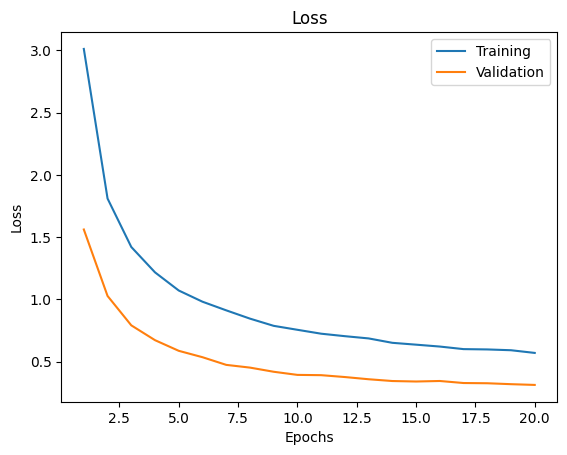

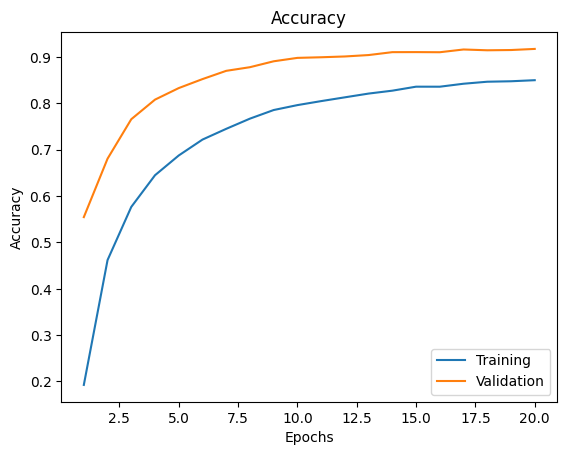

In [ ]:
# Plotting the history
plot_loss(history_drop)
plot_accuracy(history_drop)

> Dropout seems to generalize better than both L1 and L2, having the best performance in validation. The following section will try to find a better tradeoff, trying to improve the performance while keeping the generalization.

### **1.2.1 Regularized Model - Building the network**


> Dropout seems to be a really good choice based on the study done in the previous section. Let's create a new model together with the early stopping technique to obtain and train our final regularized model.

> In this specific case, 0.3 seems to provide a good balance between retaining enough information and preventing overfitting, increasing to the lower layers up to 0.5.

In [ ]:
# The model is built following the non-regularized one.
model_reg= Sequential()
model_reg.add(Input((dims,)))
model_reg.add(Dense(512, activation = "relu"))
model_reg.add(Dropout(0.3))
model_reg.add(Dense(256, activation = "relu"))
model_reg.add(Dropout(0.3))
model_reg.add(Dense(128, activation = "relu"))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(64, activation = "relu"))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(nb_classes, activation = "softmax"))
# Compiling the model
model_reg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_reg.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

### **1.2.2 Analyze and comment on the training results**

When using early stopping, the following main parameters can be chosen:

* *monitor* = quantity to be monitored.
* *patience* = number of epochs with no improvement after which training will be stopped.
* *mode* = one of {"auto", "min", "max"}.

In [ ]:
# Monitoring the loss in validation.
# Since we see a quick convergence with 20 epochs, the patience value will be low aswell
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto')

> Fitting the network using early stopping.

In [ ]:
# Fitting the model, 1000 epochs as its expected to stop much earlier thanks to early stopping
history_reg = model_reg.fit(X_train, y_train, batch_size=128, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1689 - loss: 3.2212 - val_accuracy: 0.7285 - val_loss: 1.0279
Epoch 2/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5937 - loss: 1.4286 - val_accuracy: 0.8198 - val_loss: 0.6386
Epoch 3/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7121 - loss: 1.0336 - val_accuracy: 0.8562 - val_loss: 0.5043
Epoch 4/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7682 - loss: 0.8292 - val_accuracy: 0.8847 - val_loss: 0.4201
Epoch 5/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8035 - loss: 0.7228 - val_accuracy: 0.8974 - val_loss: 0.3908
Epoch 6/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8267 - loss: 0.6406 - val_accuracy: 0.9032 - val_loss: 0.3590
Epoch 7/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8393 - loss: 0.5942 - val_accuracy: 0.9127 - val_loss: 0.3363
Epoch 8/1000
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8548 - loss: 0.5479 -

> We can see how the accuracy of training and validation this time are much closer, and higher in validation.

### **1.2.3 Validate the model and comment on the results**

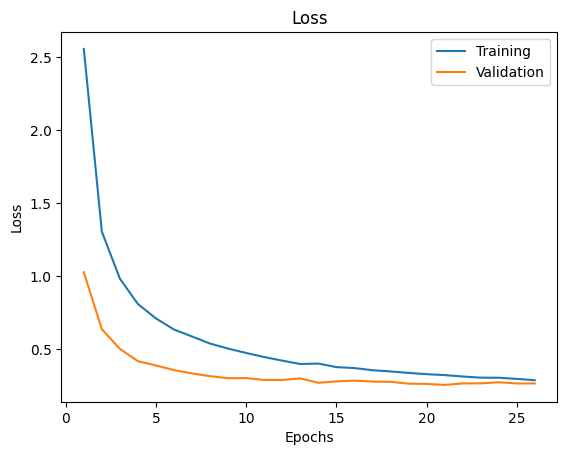

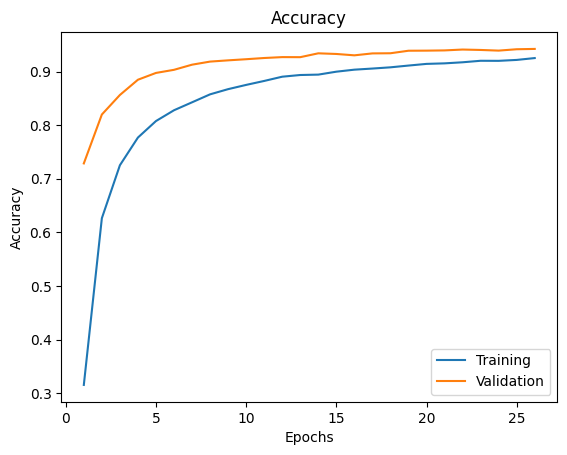

In [ ]:
# Plotting the history
plot_loss(history_reg)
plot_accuracy(history_reg)

> Altering the percentage near the input layer helped the model with performance in both training and validation, while keeping the generalization properties as we see no overfitting. Early Stopping also helped with the choice of the optimal epoch.

## **1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment on the results**

Visualize, describe and interpret the evaluation procedure and results on the provided test set, with a focus on the generalization capability of your models.



Based on the results obtained and analyzed during the training and the validation phases, what were your (rather _personal_) expectations with respect to the performances of your models on a blind external test set?

What are the differences between results on the validation set and the actual result on the test set (if any)? What could have caused them? Briefly motivate your answer.

After the comparison, what is the overall "best" model? Why?

For the model that you consider the "best", what are the major sources of error? Are there any classes/labels (or data samples in general) where the model is struggling the most? Why?

> On the test set the expectations are that the regularized model will perform slightly better than the non-regularized model, not necessarily in terms of accuracy, but also in terms of loss. The main goal is to achieve a more stable model that generalizes better with more consistent performance in both training and test data.

In [ ]:
# Evaluating the model on the test set
test_loss_noreg, test_accuracy_noreg = model_noreg.evaluate(X_test, y_test)

# Printing the results
print(f"Test Loss: {test_loss_noreg}")
print(f"Test Accuracy: {test_accuracy_noreg}")

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.3118
Test Loss: 0.31124138832092285
Test Accuracy: 0.9398745894432068


In [ ]:
# Evaluating the model on the test set
test_loss_reg, test_accuracy_reg = model_reg.evaluate(X_test, y_test)

# Printing the results
print(f"Test Loss: {test_loss_reg}")
print(f"Test Accuracy: {test_accuracy_reg}")

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9425 - loss: 0.2704
Test Loss: 0.2573339343070984
Test Accuracy: 0.9426151514053345


> Both models perform very well in terms of accuracy. However, the regularized model shows a significantly lower loss, which indicates that the regularization techniques have helped the model generalize better to unseen data. This results in a more stable model when applied to the test set, suggesting that the regularization has prevented overfitting, which in this case is the best one compared to the non-regularized.

> Also, the performance on the test set is very close to the validation performance, indicating that the models have successfully adapted to new, unseen data without much problems. This suggests that both models, especially the regularized one, have achieved good generalization in this case.

In [ ]:
# Predict the classes
y_pred_noreg = model_noreg.predict(X_test)

# Convert probabilities to class labels (since we have softmax)
# We will have [0, 49] range for onehot encoding
y_pred_class_noreg = np.argmax(y_pred_noreg, axis=1)

753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
# For accuracy, let's calculate with conf_matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_class_noreg)

# Accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print all the accuracies (in the format 0-49)
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: Accuracy = {accuracy:.2f}")

Class 0: Accuracy = 0.98
Class 1: Accuracy = 0.78
Class 2: Accuracy = 0.95
Class 3: Accuracy = 0.95
Class 4: Accuracy = 0.97
Class 5: Accuracy = 0.96
Class 6: Accuracy = 0.92
Class 7: Accuracy = 0.87
Class 8: Accuracy = 0.93
Class 9: Accuracy = 0.97
Class 10: Accuracy = 0.98
Class 11: Accuracy = 0.91
Class 12: Accuracy = 0.89
Class 13: Accuracy = 0.92
Class 14: Accuracy = 0.96
Class 15: Accuracy = 0.98
Class 16: Accuracy = 0.86
Class 17: Accuracy = 0.90
Class 18: Accuracy = 0.97
Class 19: Accuracy = 0.96
Class 20: Accuracy = 0.93
Class 21: Accuracy = 0.92
Class 22: Accuracy = 0.91
Class 23: Accuracy = 0.90
Class 24: Accuracy = 0.80
Class 25: Accuracy = 0.99
Class 26: Accuracy = 0.96
Class 27: Accuracy = 0.92
Class 28: Accuracy = 0.92
Class 29: Accuracy = 0.76
Class 30: Accuracy = 0.93
Class 31: Accuracy = 0.92
Class 32: Accuracy = 0.95
Class 33: Accuracy = 0.93
Class 34: Accuracy = 0.97
Class 35: Accuracy = 0.95
Class 36: Accuracy = 0.87
Class 37: Accuracy = 0.87
Class 38: Accuracy = 0

In [ ]:
# Classification report for the other metrics
print("Classification Report for Non-Regularized Model:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_class_noreg))

Classification Report for Non-Regularized Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       801
           1       0.83      0.78      0.81        77
           2       0.94      0.95      0.95       638
           3       0.96      0.95      0.96       676
           4       0.95      0.97      0.96       606
           5       0.96      0.96      0.96       188
           6       0.93      0.92      0.93       697
           7       0.93      0.87      0.90       185
           8       0.92      0.93      0.92       667
           9       0.98      0.97      0.97       771
          10       0.99      0.98      0.99       876
          11       0.96      0.91      0.93       261
          12       0.87      0.89      0.88        82
          13       0.93      0.92      0.92       202
          14       0.96      0.96      0.96       687
          15       0.98      0.98      0.98       751
          16       0.89      0.8

In [ ]:
# Predictions
y_pred_reg = model_reg.predict(X_test)
y_pred_class_reg = np.argmax(y_pred_reg, axis=1)

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# For accuracy, let's calculate with conf_matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_class_reg)

# Accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print all the accuracies (in the format 0-49)
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: Accuracy = {accuracy:.2f}")

Class 0: Accuracy = 0.98
Class 1: Accuracy = 0.79
Class 2: Accuracy = 0.94
Class 3: Accuracy = 0.96
Class 4: Accuracy = 0.96
Class 5: Accuracy = 0.96
Class 6: Accuracy = 0.95
Class 7: Accuracy = 0.84
Class 8: Accuracy = 0.90
Class 9: Accuracy = 0.98
Class 10: Accuracy = 0.99
Class 11: Accuracy = 0.95
Class 12: Accuracy = 0.91
Class 13: Accuracy = 0.89
Class 14: Accuracy = 0.97
Class 15: Accuracy = 0.97
Class 16: Accuracy = 0.90
Class 17: Accuracy = 0.82
Class 18: Accuracy = 0.98
Class 19: Accuracy = 0.96
Class 20: Accuracy = 0.94
Class 21: Accuracy = 0.95
Class 22: Accuracy = 0.91
Class 23: Accuracy = 0.89
Class 24: Accuracy = 0.84
Class 25: Accuracy = 0.98
Class 26: Accuracy = 0.94
Class 27: Accuracy = 0.90
Class 28: Accuracy = 0.92
Class 29: Accuracy = 0.71
Class 30: Accuracy = 0.98
Class 31: Accuracy = 0.93
Class 32: Accuracy = 0.92
Class 33: Accuracy = 0.95
Class 34: Accuracy = 0.94
Class 35: Accuracy = 0.96
Class 36: Accuracy = 0.93
Class 37: Accuracy = 0.86
Class 38: Accuracy = 0

In [ ]:
# Classification report
print("Classification Report for Regularized Model:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_class_reg))

Classification Report for Regularized Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       801
           1       0.82      0.79      0.81        77
           2       0.95      0.94      0.94       638
           3       0.94      0.96      0.95       676
           4       0.95      0.96      0.95       606
           5       0.97      0.96      0.97       188
           6       0.92      0.95      0.93       697
           7       0.93      0.84      0.88       185
           8       0.90      0.90      0.90       667
           9       0.97      0.98      0.97       771
          10       0.98      0.99      0.98       876
          11       0.94      0.95      0.94       261
          12       0.84      0.91      0.88        82
          13       0.93      0.89      0.91       202
          14       0.96      0.97      0.96       687
          15       0.98      0.97      0.98       751
          16       0.87      0.90   

> The accuracies and classification reports show similar data for both the regularized and non-regularized model. Though, it's possible to analyze which labels both the models tend to struggle with, as for example:
  - 2 (1)
  - 8 (7)
  - 13 (12)
  - 18 (17)
  - 30 (29)

> It seems like the models struggle to identify these numbers, which are also the least frequent in the distribution studied in the *Inspecting the Data - Plots*, which seem to be the main cause of lowered performance.

> Let's analyze some of the missclassified images, because there could be aswell some numbers drawn in a very ambiguous way that "trick" the models.

In [ ]:
# Function for showing the misclassified images
def show_missclassified(data, y_pred, num_images=10):
    # Setting up the size of the figure
    plt.figure(figsize=(20, 10))
    # Plotting each image
    for idx, i in enumerate(data[:num_images]):
        plt.subplot(1, num_images, idx+1)
        plt.imshow(X_test[i].reshape(28, 39))
        # Since our labels are in the onehot encoded range [0, 49] we need to sum 1 in order to
        # have the correct match between the text written in title and image.
        plt.title(f"True: {np.argmax(y_test[i]) + 1}, Pred: {y_pred[i] + 1}")
        plt.axis('off')
    plt.show()

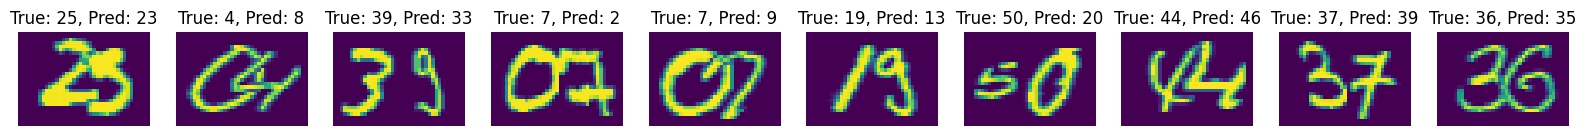

In [ ]:
# We find the missclassified values. argmax is needed since we have onehot encoded labels
misclassified_indices_noreg = np.where(y_pred_class_noreg != np.argmax(y_test, axis=1))[0]
# Display the first 10 misclassifications
show_missclassified(misclassified_indices_noreg, y_pred_class_noreg)

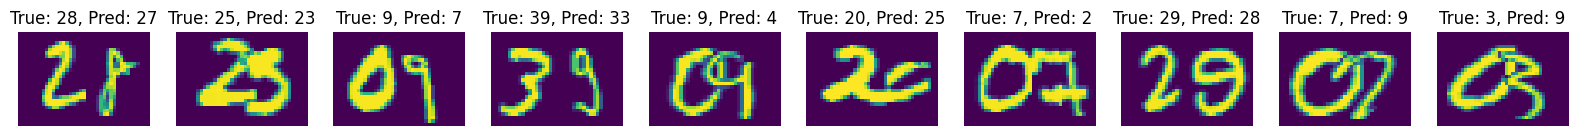

In [ ]:
# We find the missclassified values. argmax is needed since we have onehot encoded labels
misclassified_indices_reg = np.where(y_pred_class_reg != np.argmax(y_test, axis=1))[0]
# Display the first 10 misclassifications
show_missclassified(misclassified_indices_reg, y_pred_class_reg)

> Both the models seem to struggle recognising the 3 and 5, swapping them. The same can be said with 7 and 9 but generally some images are really ambiguous and the models indeed missclassify them.

In [ ]:
# Finally, let's see the missclassifications on the "worse" labels
specific_labels = [1, 7, 12, 17, 29]  # Corresponding to labels 2, 8, 13, 18, 30
# Filtering
misclassified_specific_noreg = [i for i in misclassified_indices_noreg if np.argmax(y_test[i]) in specific_labels]
misclassified_specific_reg = [i for i in misclassified_indices_reg if np.argmax(y_test[i]) in specific_labels]

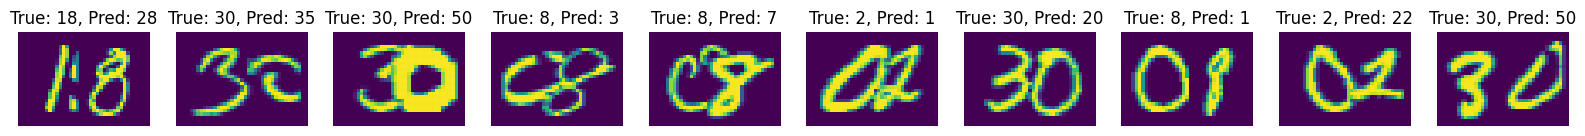

In [ ]:
show_missclassified(misclassified_specific_noreg, y_pred_class_noreg)

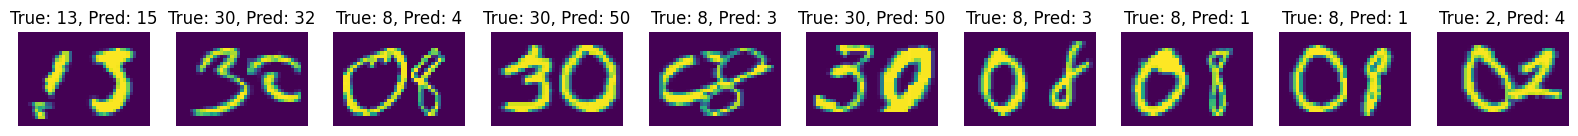

In [ ]:
show_missclassified(misclassified_specific_reg, y_pred_class_reg)

> Here, we can see especially with the number 8, depending on how it's drawn, how the models missclassify the label for similar numbers, like 1.

# **2. The development of a simple auto-encoder model  [Mandatory]**
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## **2.1 Building the network**

> The autoencoder is built following these rules:
- **encoding_dim**: 48, as stated by the request, 1092 (the real size of imgs) divided by this number need to result in a range between 20 and 30. 48 is a good choice as 1092 /48 = 22.7 compression factor. Moreover it's close to a power of 2.

> - **hidden_layers**: there are three hidden layers for downsampling and upsampling the data. In the downsampling part, the number of neurons is halved at each layer: starting from an input size of 1092, the first hidden layer reduces it to 512 neurons, followed by 256, then 128, and finally around 64 neurons (48 in this case, which is close to 64).

> - The output activation function is **sigmoid** because it produces values in the range [0,1], which aligns with our pixel normalization.

In [ ]:
# Getting back the dims
dims = X_train.shape[1]
encoding_dim = 48  # 1092 /48 = 22.7
activation = "relu"

# Input placeholder with 1092
input = Input(shape=(dims,))

# Hidden layers for downsampling
downsampling_hidden_1 = Dense(512, activation=activation, name="downsampling_hidden_1")(input)
downsampling_hidden_2 = Dense(256, activation=activation, name="downsampling_hidden_2")(downsampling_hidden_1)
downsampling_hidden_3 = Dense(128, activation=activation, name="downsampling_hidden_3")(downsampling_hidden_2)

# Encoded representation with the updated encoding dimension (latent)
encoded = Dense(encoding_dim, activation=activation, name="latent")(downsampling_hidden_3)

# Hidden layers for upsampling
upsampling_hidden_1 = Dense(128, activation=activation, name="upsampling_hidden_1")(encoded)
upsampling_hidden_2 = Dense(256, activation=activation, name="upsampling_hidden_2")(upsampling_hidden_1)
upsampling_hidden_3 = Dense(512, activation=activation, name="upsampling_hidden_3")(upsampling_hidden_2)

# Lossy reconstruction of the input
decoded = Dense(dims, activation='sigmoid', name="decoder")(upsampling_hidden_3)

# Autoencoder model mapping input to its reconstruction
autoencoder = Model(input, decoded)

In [ ]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 48)                  │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461,108 (5.57 MB)

 Trainable params: 1,461,108 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

### **2.1.1 Building the network: Submodels**


> It’s possible to "split" the autoencoder into two separate models that still point to the full autoencoder:
  - **Encoder**: This is the first part of the autoencoder. It takes the original input data and "encodes" it into a compressed, latent representation.
  - **Decoder**: This is the second part of the autoencoder. It takes the latent representation (the encoded data) and "decodes" it back to reconstruct the output.


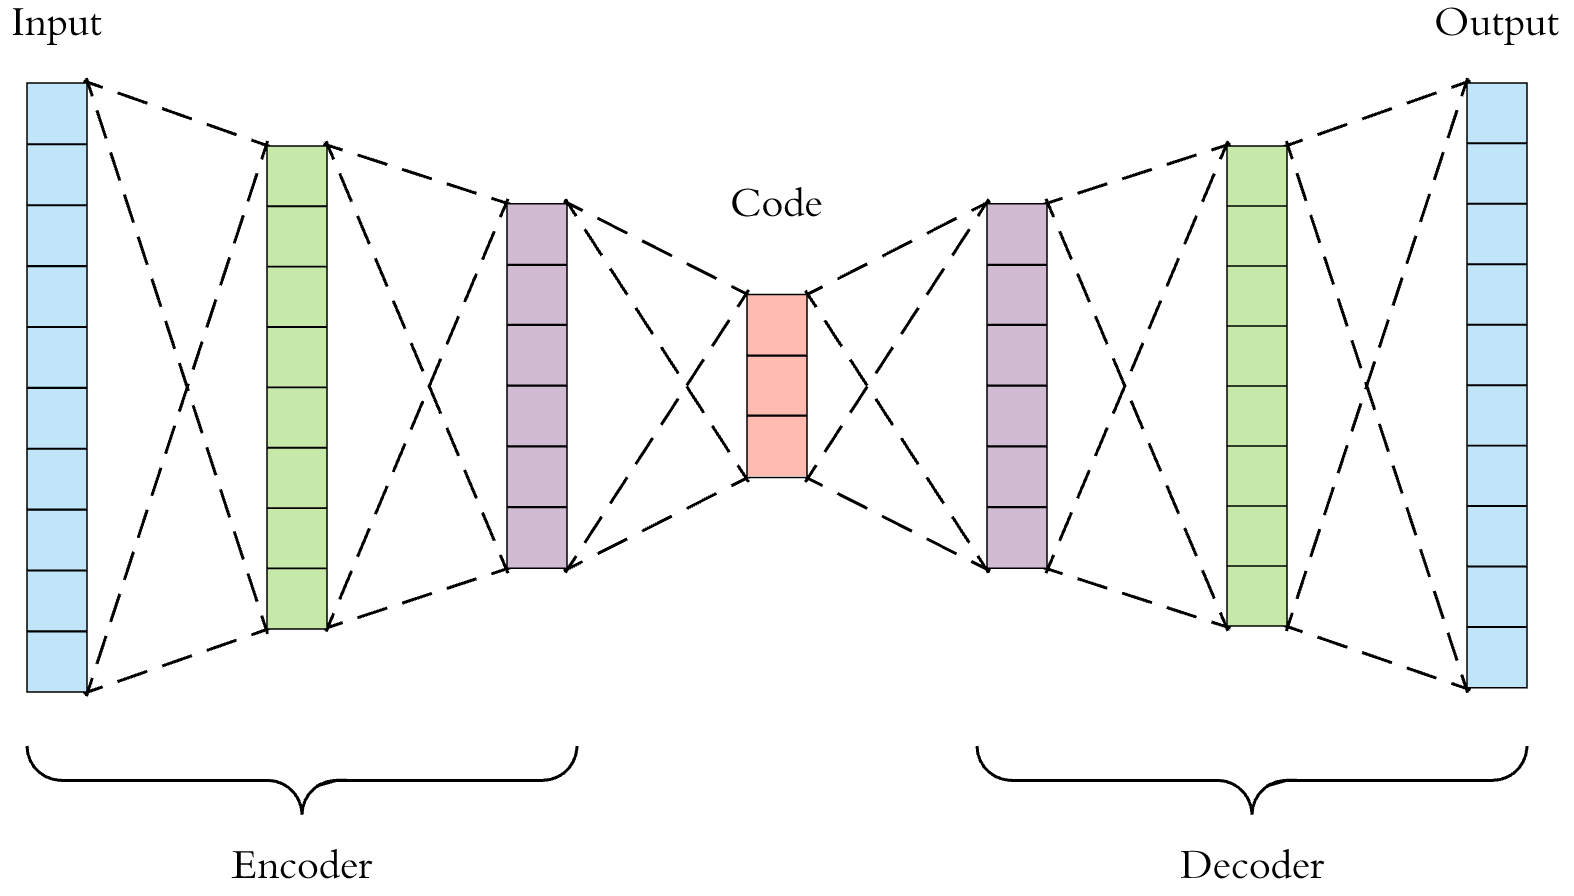

#### **Submodels: Encoder**


In [ ]:
## Encoder

# Mapping the input to the encoded rappresentation
encoder_model = Model(input, encoded)
# Summary of the encoder part
encoder_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 48)                  │           6,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 730,032 (2.78 MB)

 Trainable params: 730,032 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

> As seen in the summary, the *encoder_model* contains the submodel of the autoencoder that is going to encode our input.

#### **Submodels: Decoder**


In [ ]:
## Decoder

# Mapping the latent rappresentation to the decoded (output)
decoder_model = Model(encoded, decoded)
# Summary of the decoder part
decoder_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_22CLONE (InputLayer)    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,076 (2.79 MB)

 Trainable params: 731,076 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

> As seen in the summary, the *decoder_model* contains the submodel of the autoencoder that is going to decode form the latent rappresentation.

### **2.1.2 Building the network: Fitting the Autoencoder**


> For compiling the autoencoder the main difference to the NN seen in the previous sections is in the metrics.

> The *Mean Squared Error (MSE)* is often used as a metric in autoencoders to provide insight into the reconstruction quality.

In [ ]:
# Compile the autoencoder model

# Binary Crossentropy since it calculates the difference between the input and output in terms of probability
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics = ["mse"])

# Summary of the model
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 48)                  │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461,108 (5.57 MB)

 Trainable params: 1,461,108 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

> Let's now train the autoencoder. The training process is almost identical to that of a regular NN, but here, *y_train* is replaced by *X_train*. This is because the goal of the autoencoder is to reconstruct the input data as accurately as possible, minimizing the error between the input and the output.

In [ ]:
# 50 epochs and batch_size to 1024 for a quick training
network_history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=1024, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - loss: 0.3390 - mse: 0.0794 - val_loss: 0.3033 - val_mse: 0.0669
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - loss: 0.2938 - mse: 0.0637 - val_loss: 0.2742 - val_mse: 0.0567
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - loss: 0.2668 - mse: 0.0543 - val_loss: 0.2482 - val_mse: 0.0479
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - loss: 0.2432 - mse: 0.0460 - val_loss: 0.2340 - val_mse: 0.0430
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - loss: 0.2293 - mse: 0.0412 - val_loss: 0.2235 - val_mse: 0.0392
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - loss: 0.2199 - mse: 0.0380 - val_loss: 0.2155 - val_mse: 0.0363
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - loss: 0.2126 - mse: 0.0355 - val_loss: 0.2089 - val_mse: 0.0341
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - loss: 0.2076 - mse: 0.0337 - val_loss: 0.2040 - val_mse: 0.0324
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/

## **2.2 Visually Inspecting the results**

> In this section, we will investigate the reconstruction capabilities of our autoencoder. We will compare 10 samples before encoding (the input data) and after they pass through the autoencoder (the final output). This comparison will help us tell how accurately the autoencoder can reconstruct the original input images.

In [ ]:
# Function that plots the results of the autoencoder and input data
def plot_autoencoder(input, output, n = 10):
  # Plotting the figures
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Original Images
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(input[i].reshape(28, 39))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      # Reconstructed Images
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(output[i].reshape(28, 39))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


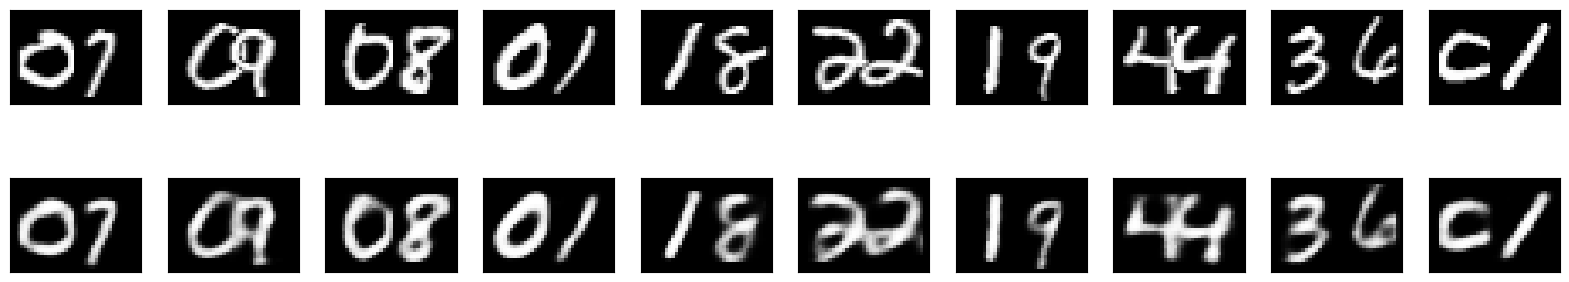

In [ ]:
# Selecting the data to use for predict
in_imgs = X_test

# Using the full autoencoder
pred_imgs = autoencoder.predict(in_imgs)

# Plotting the results
plot_autoencoder(in_imgs, pred_imgs)

In [ ]:
# Printing the MAE and MSE to analyze the results
print(mean_absolute_error(in_imgs, pred_imgs))
print(mean_squared_error(in_imgs, pred_imgs))

0.05618929
0.016693158



> Analyzing the results given by MAE and MSE we can say that the autoencoder is able to generalize well, retaining critical image features with little errors. In the specific:

> - **Mean Absolute Error (MAE)**: The MAE value of approximately 0.056 suggests that, on average, the absolute difference between each pixel in the original (in_imgs) and reconstructed (pred_imgs) images is indeed 0.056. This is a relatively small error which tells that the autoencoder is capturing most of the important details with minimal deviation in the reconstruction.

> - **Mean Squared Error (MSE)**: The MSE value of about 0.0166 reflects the squared differences between pixels in the original and reconstructed images. Since MSE penalizes larger errors more heavily than MAE, it gives an indication of whether there are significant discrepancies in some pixel values. In this case the MSE is close to zero, so it suggests that the autoencoder is generally reconstructing the images well, with few pixel errors.

## **2.3 Generate new samples**

> In this section, we generate 20 sample images by giving randomly generated encoding vectors to the autoencoder. This approach helps us examine how well the decoder can produce recognizable digit patterns from random points in the latent space. Even if the outputs may appear blurry because of the randomness, they should provide some information about the autoencoder ability to capture meaningful representations and generalize from the training data.

In [ ]:
# Function that shows the generated samples
def show_samples(decoded_imgs, n = 20):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Plotting n images
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 39))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


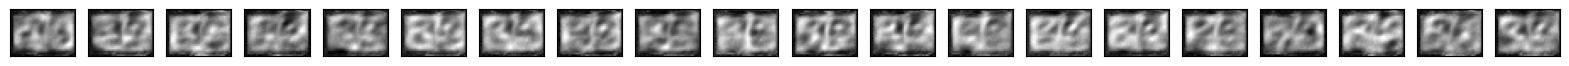

In [ ]:
# Number of images to be generated
n_imgs = 20
# encoding_dim = 48
random_encodings = np.random.rand(n_imgs, encoding_dim)
# Predicting using the random encodings
decoded_imgs = decoder_model.predict(random_encodings)
# Plot the images
show_samples(decoded_imgs, n_imgs)

> The samples above show that the autoencoder outputs indeed carry some recognizable features, even if they are blurry. The generated images appear to resemble various numbers, although they look like merged or superimposed versions of different digits.

> For example, it’s possible to make out shapes similar to the number 3 (as seen in the last sample) and the number 4 (in sample 7). This suggests that the random encodings still produce outputs loosely influenced by the autoencoder training.

# **3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.**

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


### **3.A Preliminaries**

> For this task the model that will be used to evaluate the performances with the latent rappresentation will be the XGBoost as suggested in the description of the task.

> Before implementing the actual model, let's prepare the data.

In [ ]:
# Function that shows the mlogloss in train and validation of xgboost
def show_xgboost(results):
  # Extract the evaluation metrics from the history
  train_logloss = results.evals_result()['validation_0']['mlogloss']
  val_logloss = results.evals_result()['validation_1']['mlogloss']
  # Plot the learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(train_logloss, label='Training Log Loss')
  plt.plot(val_logloss, label='Validation Log Loss')
  plt.xlabel('Boosting Round')
  plt.ylabel('Log Loss')
  plt.title('LogLoss Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

> Encoding X_train and X_test using the autoencoder implemented in Section 2.
XGBoost supports validation data so the validation set can be encoded and used.

In [ ]:
# Obtaining the encoded X_train and X_test
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)
# Since xgboost supports validation we are going to encode X_val as well
X_val_encoded = encoder_model.predict(X_val)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


> One-Hot Encoding is not compatible with XGBoost, so we revert the labels to the original state (before the conversion).

In [ ]:
# Converting back from one-hot encoding
y_train_xgb = y_train.argmax(axis=1)
y_test_xgb  = y_test.argmax(axis=1)
y_val_xgb  = y_val.argmax(axis=1)

### **3.A XGBoost using Autoencoder Latents**

> XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm based on gradient boosting. It builds an ensemble of decision trees in sequence, where each tree corrects errors made by the previous ones. Like the NN it supports a lot of parameters, like:

> - **objective='multi:softmax'**: Specifies that the model is performing multi-class classification. It uses the softmax function to predict the class with the highest probability. Outputs a single class label for each instance.

> - **eval_metric=["mlogloss", "merror"]**:  
  - **mlogloss**: Multiclass log loss, evaluates how close predicted probabilities are to true labels (lower is better). It can be seen as the loss of NN.
  - **merror**: Multiclass error rate, measures the proportion of misclassified instances (lower is better). **1 - merror** returns the accuracy like a NN.

In [ ]:
# Using XGBoost with generally default values, eval_metric for mlogloss and merror for accuracy
xgb_classifier_encoded = XGBClassifier(n_estimators=100, objective='multi:softmax', enable_categorical=True,  eval_metric=["mlogloss", "merror"], early_stopping_rounds=10, learning_rate=0.05, max_depth=10)

In [ ]:
# Fitting the model
encoded_results = xgb_classifier_encoded.fit(X_train_encoded, y_train_xgb, eval_set=[(X_train_encoded, y_train_xgb), (X_val_encoded, y_val_xgb)])

[0]	validation_0-mlogloss:3.45527	validation_0-merror:0.31228	validation_1-mlogloss:3.56027	validation_1-merror:0.51417
[1]	validation_0-mlogloss:3.15042	validation_0-merror:0.23737	validation_1-mlogloss:3.33543	validation_1-merror:0.45305
[2]	validation_0-mlogloss:2.91270	validation_0-merror:0.19295	validation_1-mlogloss:3.16124	validation_1-merror:0.42005
[3]	validation_0-mlogloss:2.71532	validation_0-merror:0.16305	validation_1-mlogloss:3.01983	validation_1-merror:0.40101
[4]	validation_0-mlogloss:2.54789	validation_0-merror:0.14312	validation_1-mlogloss:2.90019	validation_1-merror:0.38838
[5]	validation_0-mlogloss:2.40196	validation_0-merror:0.12826	validation_1-mlogloss:2.79628	validation_1-merror:0.37709
[6]	validation_0-mlogloss:2.27122	validation_0-merror:0.11428	validation_1-mlogloss:2.70343	validation_1-merror:0.36845
[7]	validation_0-mlogloss:2.15370	validation_0-merror:0.10317	validation_1-mlogloss:2.61994	validation_1-merror:0.36004
[8]	validation_0-mlogloss:2.04781	valida

#### **3.A XGBoost using Autoencoder Latents: LogLoss Plot**

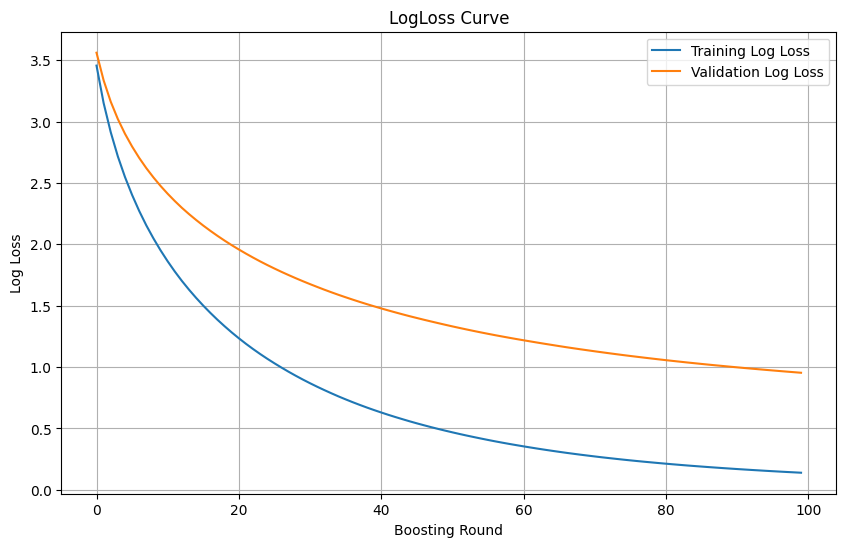

In [ ]:
# Plotting the LogLoss
show_xgboost(encoded_results)

> It's very evident that the model is overfitting as the loss in training is much lower than in validation. In the following section there will be a more in depth evaluation.

#### **3.A XGBoost using Autoencoder Latents: Evalutation**

In [ ]:
# Predict with XGBoost on training, validation, and test sets
y_pred_train_encoded = xgb_classifier_encoded.predict(X_train_encoded)
y_pred_val_encoded = xgb_classifier_encoded.predict(X_val_encoded)
y_pred_test_encoded = xgb_classifier_encoded.predict(X_test_encoded)

# Calculate accuracy for train, validation, and test sets
accuracy_train_encoded = accuracy_score(y_train_xgb, y_pred_train_encoded)
accuracy_val_encoded = accuracy_score(y_val_xgb, y_pred_val_encoded)
accuracy_test_encoded = accuracy_score(y_test_xgb, y_pred_test_encoded)

# Print the accuracy results
print(f"XGBoost Encoded Training Accuracy: {accuracy_train_encoded * 100:.2f}%")
print(f"XGBoost Encoded Validation Accuracy: {accuracy_val_encoded * 100:.2f}%")
print(f"XGBoost Encoded Test Accuracy: {accuracy_test_encoded * 100:.2f}%")

XGBoost Encoded Training Accuracy: 99.91%
XGBoost Encoded Validation Accuracy: 75.55%
XGBoost Encoded Test Accuracy: 75.66%


In [ ]:
# For the loss we need the probability
y_test_pred_proba_encoded = xgb_classifier_encoded.predict_proba(X_test_encoded)

# Calculate the log loss
test_mlogloss_encoded = log_loss(y_test_xgb, y_test_pred_proba_encoded)
print(f"Test Loss Encoded (mlogloss): {test_mlogloss_encoded:.4f}")

Test Loss Encoded (mlogloss): 0.9473


> As a result, it is clear that the model performs significantly worse on the test set, with a noticeable drop of about 25% in accuracy. The loss on the test set is considerably higher compared to the training loss, which is near 0. This discrepancy strongly suggests that the model is overfitting to the training data, learning patterns that do not generalize well to unseen data.

### **3.A Principal Component Analysis**

> Before implementing the second model as requested in the task, let's apply a dimensionality reduction technique like PCA. This will help have a much quicker training (XGBoost is already slow with the encoded data) and also have a better comparasion. It's clear that the original data will perform better than the encoded one but having PCA could help to tell if the encodings of our autoencoder are actually useful.

In [ ]:
pca = PCA().fit(X_train)

> Plotting the results of PCA can give an idea of how much variance (information) of the data can be kept as components.

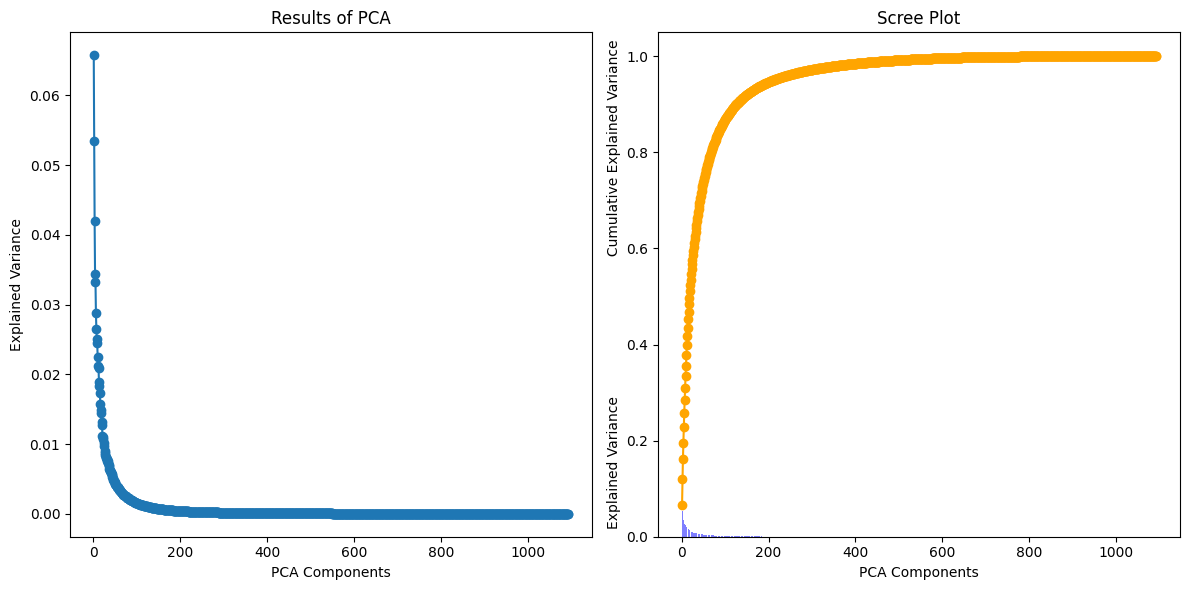

In [ ]:
# Grafico varianza spiegata per ogni componente
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.title("Results of PCA")

# Calcola la varianza spiegata cumulativa e crea lo scree plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1, 2, 2)
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.5, align='center')
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance                                Cumulative Explained Variance')
plt.title("Scree Plot")

plt.tight_layout()
plt.show()

> We will keep about 80% of explained variance. This is usually a good tradeoff and also close to the delta between the train accuracy and test accuracy seen with XGBoost with the encodings.

In [ ]:
# Dimensionality reduction with 80% of explained variance
pca = PCA(n_components=0.8).fit(X_train)
pca_train = pca.transform(X_train)
pca_val = pca.transform(X_val)
pca_test = pca.transform(X_test)

In [ ]:
# Print the number of components
print("Number of components:", pca.n_components_)

Number of components: 68


### **3.A XGBoost using PCA**

> The model is identical to the one used for the encodings, but now uses the data for PCA.

In [ ]:
xgb_classifier_pca = XGBClassifier(n_estimators=100, objective='multi:softmax', enable_categorical=True,  eval_metric=["mlogloss", "merror"], early_stopping_rounds=10, learning_rate=0.05, max_depth=10)

In [ ]:
pca_results = xgb_classifier_pca.fit(pca_train, y_train_xgb, eval_set=[(pca_train, y_train_xgb), (pca_val, y_val_xgb)])

[0]	validation_0-mlogloss:3.41184	validation_0-merror:0.29623	validation_1-mlogloss:3.49868	validation_1-merror:0.46141
[1]	validation_0-mlogloss:3.10076	validation_0-merror:0.23602	validation_1-mlogloss:3.25411	validation_1-merror:0.40389
[2]	validation_0-mlogloss:2.86343	validation_0-merror:0.20059	validation_1-mlogloss:3.07102	validation_1-merror:0.37692
[3]	validation_0-mlogloss:2.66841	validation_0-merror:0.17837	validation_1-mlogloss:2.92407	validation_1-merror:0.36308
[4]	validation_0-mlogloss:2.50111	validation_0-merror:0.15975	validation_1-mlogloss:2.79900	validation_1-merror:0.35278
[5]	validation_0-mlogloss:2.35641	validation_0-merror:0.14521	validation_1-mlogloss:2.69103	validation_1-merror:0.34426
[6]	validation_0-mlogloss:2.22816	validation_0-merror:0.13373	validation_1-mlogloss:2.59604	validation_1-merror:0.33773
[7]	validation_0-mlogloss:2.11346	validation_0-merror:0.12367	validation_1-mlogloss:2.51121	validation_1-merror:0.33097
[8]	validation_0-mlogloss:2.01004	valida

#### **3.A XGBoost using PCA: LogLoss Plot**

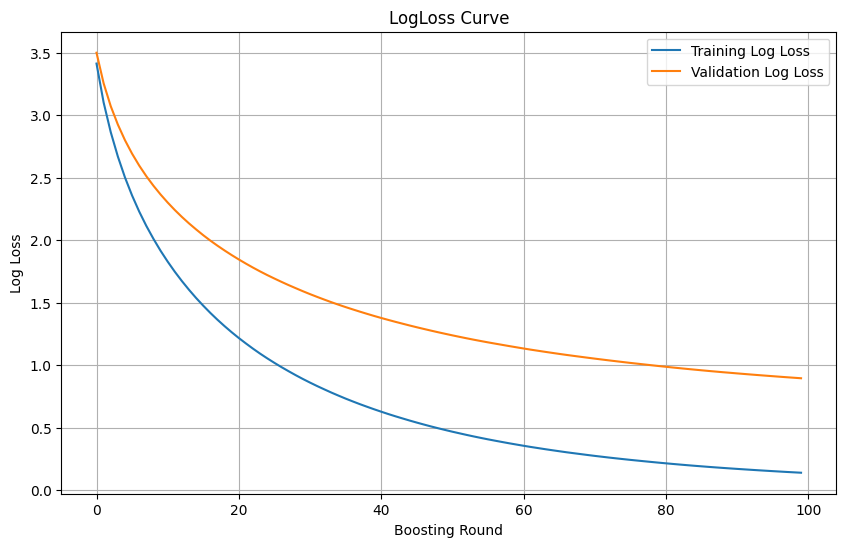

In [ ]:
show_xgboost(pca_results)

> The performance seems to be about the same of the other XGBoost model with the encodings.

#### **3.A XGBoost using PCA: Evaluation**

In [ ]:
# Predict with XGBoost on training, validation, and test datasets
y_pred_train_pca = xgb_classifier_pca.predict(pca_train)
y_pred_val_pca = xgb_classifier_pca.predict(pca_val)
y_pred_test_pca = xgb_classifier_pca.predict(pca_test)

# Calculate accuracy for train, validation, and test sets
accuracy_train_pca = accuracy_score(y_train_xgb, y_pred_train_pca)
accuracy_val_pca = accuracy_score(y_val_xgb, y_pred_val_pca)
accuracy_test_pca = accuracy_score(y_test_xgb, y_pred_test_pca)

# Print the accuracy results
print(f"XGBoost PCA Training Accuracy: {accuracy_train_pca * 100:.2f}%")
print(f"XGBoost PCA Validation Accuracy: {accuracy_val_pca * 100:.2f}%")
print(f"XGBoost PCA Test Accuracy: {accuracy_test_pca * 100:.2f}%")

XGBoost PCA Training Accuracy: 99.89%
XGBoost PCA Validation Accuracy: 76.79%
XGBoost PCA Test Accuracy: 76.53%


In [ ]:
# For the loss we need the probability
y_test_pred_proba_pca = xgb_classifier_pca.predict_proba(pca_test)

# Calculate the log loss
test_mlogloss_pca = log_loss(y_test_xgb, y_test_pred_proba_pca)
print(f"Test Loss PCA (mlogloss): {test_mlogloss_pca:.4f}")

Test Loss PCA (mlogloss): 0.9098


> Using PCA, we observe similar performance, but with noticeable overfitting on both the test and validation sets. While the metrics are slightly better, it is important to note that PCA utilized more components (68) compared to the 48 components from the autoencoder's encoded data.

### **3.A Final Comparation Between the Models**

> Finally, it is possible to compare all the models that have been implemented. Undoubtedly, the best model overall is the regularized neural network, as it is not only regularized but also makes use of the full dataset. The XGBoost models, while performing worse in terms of raw metrics, utilize significantly less data and still achieve reasonably good results. Additionally, the encodings produced from the latent space of the autoencoder prove to be as valuable as those obtained from more traditional dimensionality reduction techniques, such as Principal Component Analysis. This further confirms the effectiveness of the autoencoder in capturing meaningful features.

> | Model Name                    | Accuracy (%) | Loss |
|----------------------------|--------------|------|
| Neural Network (Regularized)   | 94.26       | 0.257 |
| XGBoost Encoded       | 75.66       | 0.947      |
| XGBoost PCA           | 76.53       | 0.909     |


# 3.B [OPTIONAL] Explain model's predictions

Take the networks defined in (1) and try to explain the predictions of the model.

*   Include at least one model-agnostic method and one model-specific method;
*   Compare the two investigated XAI methods;
*   Compare the results on the original and regularized model for a single XAI method;

### 3.B.1 XAI method definition

Describe the design choices made at this stage: why did you choose these two methods?

### 3.B.2 Result's comparison

Compare the results of both XAI methods and the results of applying the same method to different models.